### Installing required packages

In [1]:
import warnings
warnings.simplefilter(action='ignore')
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# !pip install statsmodels
import statsmodels.stats.api as sms
from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu, \
    pearsonr, spearmanr, kendalltau, f_oneway, kruskal
from statsmodels.stats.proportion import proportions_ztest

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

### Loading the dataset

In [2]:
df1 = pd.read_csv("Data/cookie_cats.csv")
df = df1.copy()
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


### Dataset Overview

In [3]:
df.tail()

,userid,version,sum_gamerounds,retention_1,retention_7
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False
90188,9999861,gate_40,16,False,False


In [4]:
df.shape

(90189, 5)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
userid,90189.00000,4998412.23450,2883285.60770,116.00000,2512230.00000,4995815.00000,7496452.00000,9999861.00000
sum_gamerounds,90189.00000,51.87246,195.05086,0.00000,5.00000,16.00000,51.00000,49854.00000


In [7]:
df.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

### Descriptive Statistics
Our two groups are 'gate30' and 'gate40' since we will do the A/B test according to our business problem. Accordingly, let's get to know our data more closely.

In [8]:
# Number of unique players in groups A and B.

df.groupby("version")[["userid"]].nunique()

,userid
version,
gate_30,44700
gate_40,45489


In [9]:
df.groupby("version").agg({"sum_gamerounds" : ["mean","max","count"]})

sum_gamerounds              
                  mean    max  count
version                             
gate_30       52.45626  49854  44700
gate_40       51.29878   2640  45489

<Axes: xlabel='version', ylabel='count'>

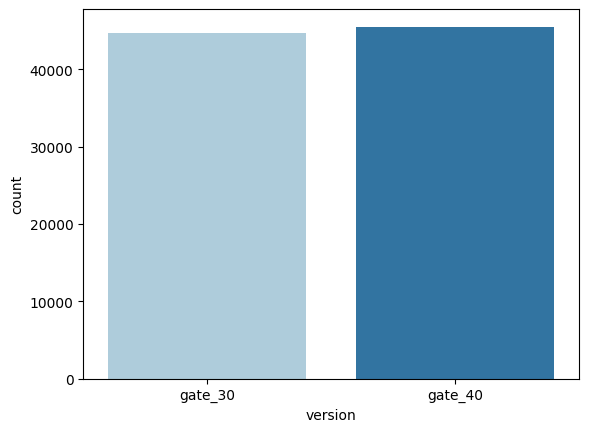

In [10]:
df.groupby("version")["sum_gamerounds"].count()
sns.countplot(x="version",palette="Paired",data=df)

<Axes: xlabel='version'>

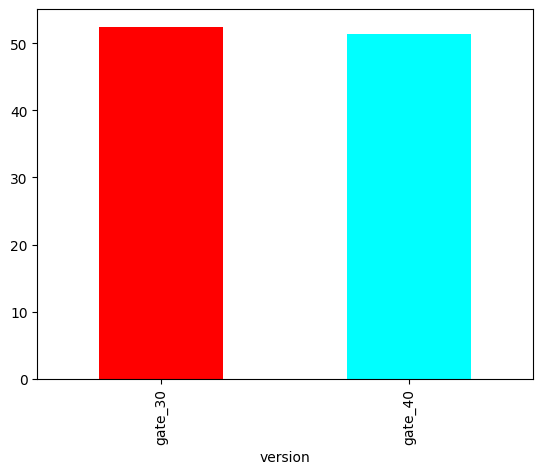

In [11]:
df.groupby("version")["sum_gamerounds"].mean().plot(kind="bar", color=[ "red", "cyan"])

If we interpret the results, the average number of game rounds seems to be more for 'gate30'. But what if it happened by chance?

# A/B Testing
<Img src="Images/AB.png">

### What is A/B Testing?
A/B testing, also known as split testing, is a method of comparing two versions of a web page or app against each other to determine which one performs better. It is a common practice used in marketing, product development, and user experience optimization to make data-driven decisions and improve overall performance.

### Why is A/B Testing done?
The primary purpose of A/B testing is to identify which variation (A or B) of a web page or app produces better results in terms of a specific key performance indicator (KPI). This could be anything from click-through rates, conversion rates, user engagement, or any other measurable metric that aligns with the organization's goals. By comparing two versions under controlled conditions, businesses can gather objective data and make informed decisions to improve their digital assets and achieve better outcomes.

### A/B Test Phases
To apply the A/B Testing for the dataset we should have follow the fundamental steps according to literature of the A/B Testing. These steps can be seen below:

- Hypothesis
- Assumptions Control
- Apply of the Hyphothesis

##### 1. Hypothesis
The hypothesis stage of A/B testing is the stage where the underlying hypothesis of the test is determined and the purpose of the experiment is clearly defined.
<br>
According to the literature, the A/B test has two hypotheses, H0 and H1. Let us explain these hypotheses.
<br>
<B>H0 : null hypothesis
<br>
H1 : alternative hypothesis</B>
<br>
The hypothesis we want to test is whether H1 is true with probability.
<br>

<b>Attention!</b>

“H0 hypothesis is rejected” or “H0 hypothesis cannot be rejected”. Therefore, an interpretation such as "H0 hypothesis is accepted" or "H1 hypothesis is accepted" cannot be made.

H0: "There is no statistically significant difference between 'gate30' and 'gate40'. "
##### 2.Assumptions Control
<b>2.1 Normal Distribution</b>
<br>
The normality assumption is based on the assumption that the data have a normal distribution. The normal distribution is a type of distribution in which the data are distributed in the form of a bell curve, symmetrical with its mean and variability with its standard deviation.
<br><br>
The assumption of normality in A/B tests is especially important so that parametric tests (for example, independent two-sample t-test) can produce accurate results. Parametric tests work on the assumption that the data fit a normal distribution, and the validity of this assumption increases the reliability of the results.
<br><br>
Various methods can be used to evaluate whether the normality assumption is valid. The Shapiro-Wilk Test is also a statistical method that tests the conformity of the data to the normal distribution. The H0 hypothesis states that the data have a normal distribution.
<br><br>
If the data do not satisfy the assumption of normality, alternative methods such as non-parametric tests (for example, Mann-Whitney U test) or transformation of the data can be used. Non-parametric tests are statistical methods that can work with data that do not satisfy the assumption of normality.

##### H0 : The assumption of normal distribution is provided.
##### H1 : The assumption of normal distribution is not provided.
##### p-value < 0.05 => H0 -> Reject
##### p-value > 0.05 => H0 -> Cannot Reject

In [12]:
# gate30

test_stat, pvalue = shapiro(df.loc[df["version"] == "gate_30", "sum_gamerounds"])
print("Test Stat = %.4f, p-value = %.4f" % (test_stat, pvalue))

Test Stat = 0.0881, p-value = 0.0000


In [13]:
# gate40

test_stat, pvalue = shapiro(df.loc[df["version"] == "gate_40", "sum_gamerounds"])
print("Test Stat = %.4f, p-value = %.4f" % (test_stat, pvalue))

Test Stat = 0.4826, p-value = 0.0000


In [14]:
# In both cases, p-value = 0. The normality assumption was rejected because it was less than 0.05.

<b>2.2 Variance Homogeneity Assumption</b>

<br>In statistical methods such as A/B testing, the assumption of homogeneity of variance is based on the assumption that data distributions between two or more groups have the same or similar variance. This assumption refers to the situation where the data of the groups show homogeneous and similar variability.
<br><br>
Homogeneity of variance is especially important in parametric tests such as ANOVA (Analysis of Variance) and independent two-sample t-test. These tests produce more reliable results when the data conform to the assumption of homogeneity of variance. If the assumption of homogeneity of variance is not valid, alternative test methods or transformations can be used.
<br><br>
Various methods can be used to control and evaluate variance homogeneity. Levene's test is a statistical test that evaluates whether the variances of the groups are homogeneous. The H0 hypothesis states that the variances of the groups are homogeneous.
<br><br>
##### H0 : The variance is homogeneous.
##### H1 : The variance is not homogeneous.
##### p-value < 0.05 => H0 -> Reject
##### p-value > 0.05 => H0 -> Cannot Reject

In [15]:
test_stat, pvalue = levene(df.loc[df["version"] == "gate_30", "sum_gamerounds"],
                            df.loc[df["version"] == "gate_40", "sum_gamerounds"])
print("Test Stat = %.4f, p-value = %.4f" % (test_stat, pvalue))

Test Stat = 0.5292, p-value = 0.4669


In [16]:
# H0 cannot be rejected because the p-value is greater than 0.05.

##### 3. Apply of the Hyphothesis
<br><br>
If the normality assumption is rejected for the A/B test, but the variance homogeneity assumption is satisfied, then it is recommended to use non-parametric test methods.
<br><br>
Non-parametric tests are statistical tests used when data do not satisfy the normality assumption or do not comply with other assumptions.
<br><br>
The <b>Mann-Whitney U Test</b> is a test used to compare two independent groups. If the homogeneity of variance assumption is not met, Welch's t-test can be used instead.
<br><br>
##### p-value < 0.05 => H0 -> Reject
##### p-value > 0.05 => H0 -> Cannot Reject

In [17]:
test_stat, pvalue = mannwhitneyu(df.loc[df["version"] == "gate_30", "sum_gamerounds"],
                            df.loc[df["version"] == "gate_40", "sum_gamerounds"])
print("Test Stat = %.4f, p-value = %.4f" % (test_stat, pvalue))

Test Stat = 1024331250.5000, p-value = 0.0502


In [18]:
# H0 cannot be rejected because the p-value is greater than 0.05.
# That is, there is no statistically significant difference between 'gate30' and 'gate40' with 95% confidence. Therefore, the result came about by chance.

#### Summary
In this notebook work, we tried to understand the business problem for Cookie Cats Games. The company was undecided about where to place the door in the game. We decided to analyze how the location of this door affects the continuation of their earnings. First of all, we got to know the dataset. Afterwards, we made a short analysis between the variables. At the end of this analysis, gate30 seemed to be more advantageous. But we needed to prove it statistically. We formed our H0 hypothesis and said 'there is no statistically significant difference between these two doors'. We then used the shapiro test for the assumption of normality and the levene test for homogeneity of variance. We used the non-parametric Mann-Whitney U Test as the normality assumption was rejected. As a result, we can say that there is no statistically significant difference between these two doors with 95% confidence. Therefore, the company can continue to use gate30.